In [1]:
import os
## plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt

# python library that manages paths
from pathlib import Path

## general mathematical and astronomical libraries
import numpy as np
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

## basic imports from Gammapy to manage data 
from gammapy.data import DataStore, EventList, GTI
from gammapy.irf import load_cta_irfs
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDatasetEventSampler, MapDataset
from gammapy.makers import MapDatasetMaker, SafeMaskMaker

In [2]:
# let's read all the event files into the DC folder:
path = Path("../sim_events")
paths = list(path.rglob("events*.fits"))

In [3]:
os.makedirs("new_events", exist_ok=True)
for i, p in enumerate(paths):
    filenumber = "{0:04d}".format(i)
    events = EventList.read(p)
    gti = GTI.read(p)
    selected_mcid = events.select_parameter(parameter="MC_ID", band=(10001, 10002))
    selected_mcid.write(f"new_events/selected_events_{filenumber}.fits", gti=gti, overwrite=True)

In [4]:
# let's read all the event files into the DC folder:
new_path = Path("./new_events/")
new_paths = list(new_path.rglob("selected_events*.fits"))

In [5]:
#let's store the files into a `DataStore` object
data_store = DataStore.from_events_files(events_paths=new_paths, 
                                         irfs_paths="../irfs/"+
                                         "astri_100_43_008_0502_C0_20_AVERAGE_50h_SC_v1.0.lv3.fits")
print(data_store)

Data store:
HDU index table:
BASE_DIR: .
Rows: 1080
OBS_ID: 0 -- 179
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']


Observation table:
Observatory name: 'N/A'
Number of observations: 180



In [6]:
# Let's save them on disk:
data_store.hdu_table.write("selected_hdu-index.fits.gz", overwrite=True)
data_store.obs_table.write("selected_obs-index.fits.gz", overwrite=True)

In [7]:
data_store = DataStore.from_dir("./", "selected_hdu-index.fits.gz", "selected_obs-index.fits.gz")
data_store.info()
observations = data_store.get_observations()
table = data_store.obs_table
pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
print(pos_obs)

Data store:
HDU index table:
BASE_DIR: .
Rows: 1080
OBS_ID: 0 -- 179
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']


Observation table:
Observatory name: 'N/A'
Number of observations: 180

<SkyCoord (Galactic): (l, b) in deg
    [(78.99824823,  1.50228951e+00), (80.50044757, -5.96089509e-04),
     (77.49961989,  3.00045604e+00), (71.99876709,  1.50162856e+00),
     (73.49941027,  6.51251308e-04), (73.49941027,  6.51251308e-04),
     (78.99824823,  1.50228951e+00), (80.50040631,  2.99951061e+00),
     (77.49961989,  3.00045604e+00), (67.49936696,  1.16689918e-03),
     (77.49961989,  3.00045604e+00), (67.49918078,  3.00135021e+00),
     (70.49873969,  3.00223675e+00), (78.99824823,  1.50228951e+00),
     (65.99850439,  1.50241276e+00), (78.99824823,  1.50228951e+00),
     (80.50044757, -5.96089509e-04), (77.49932661,  8.28882955e-04),
     (67.49936696,  1.16689918e-03), (64.49884276,  1.97004694e-0

In [8]:
pos_target = SkyCoord(73.0, 2.0, frame='galactic', unit='deg')

energy_axis = MapAxis.from_bounds(
    0.7, 100, nbin=10, name="energy", unit="TeV", interp="log"
)
geom = WcsGeom.create(
    skydir=pos_target,
    axes=[energy_axis],
    width=[22 * u.deg, 12 * u.deg],
    binsz=0.03 * u.deg,
    frame="galactic",
)

In [9]:

stacked = MapDataset.create(geom=geom)
maker = MapDatasetMaker(selection=["counts", "background", "exposure", "edisp", "psf"])
maker_safe_mask = SafeMaskMaker(methods=["aeff-default"])

for obs in observations:
    cutout = stacked.cutout(obs.pointing_radec, width="12 deg")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)   

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0
No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1
No default upper safe energy threshold defined for obs 2
No default lower safe energy threshold defined for obs 2
No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3
No default upper safe energy threshold defined for obs 4
No default lower safe energy threshold defined for obs 4
No default upper safe energy threshold defined for obs 5
No default lower safe energy threshold defined for obs 5
No default upper safe energy threshold defined for obs 6
No default lower safe energy threshold defined for obs 6
No default upper safe energy threshold defined for obs 7
No default lower safe energy threshold defined for obs 7
No default upper safe energy threshold defined for obs 8
No default lower safe energy th

In [10]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
dataset_image = stacked.to_image()

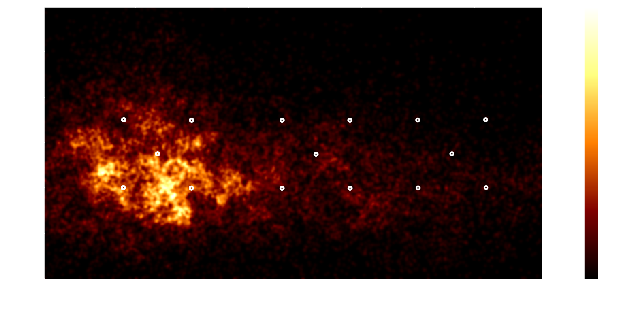

In [11]:
plt.figure(figsize=(15, 5))
counts = dataset_image.counts
ax = counts.smooth(2).plot(add_cbar=True)
ax.scatter(
    pos_obs.l.deg,
    pos_obs.b.deg,
    transform=plt.gca().get_transform("galactic"),
    color="none",
    edgecolor="white",
    marker="o",
    s=10,
    lw=1,
)
plt.show()

In [12]:
print(dataset_image.exposure.geom)
print(dataset_image.counts.geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (733, 400, 10)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 73.0 deg, 2.0 deg
	width      : 22.0 deg x 12.0 deg
	wcs ref    : 73.0 deg, 2.0 deg

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (733, 400, 1)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 73.0 deg, 2.0 deg
	width      : 22.0 deg x 12.0 deg
	wcs ref    : 73.0 deg, 2.0 deg



<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

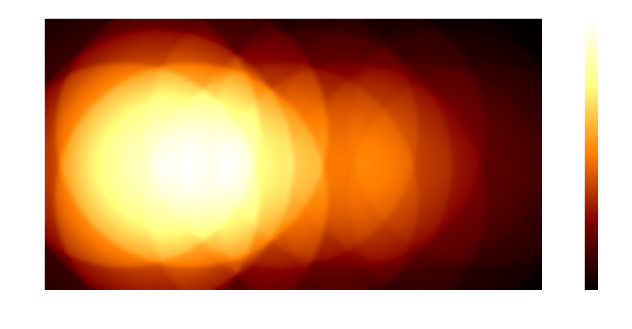

In [13]:
plt.figure(figsize=(15,5))
exposure_image = dataset_image.exposure.sum_over_axes()
exposure_image.smooth("0.1 deg").plot(add_cbar=True)

In [81]:
plt.figure(figsize=(15,5))
image_corrected = counts.data/(exposure_image.data/1.e12)
np.nan_to_num(image_corrected, nan = 0)
squeeze = np.squeeze(image_corrected)

/tmp/ipykernel_5482/1334087124.py:2: RuntimeWarning: invalid value encountered in true_divide
  image_corrected = counts.data/(exposure_image.data/1.e12)


<Figure size 1080x360 with 0 Axes>

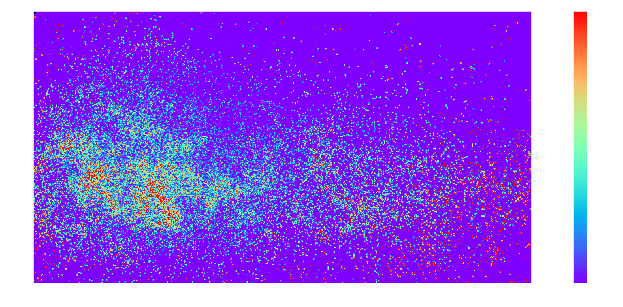

In [89]:
plt.figure(figsize=(15,5))
plt.imshow(squeeze, cmap="rainbow", vmin=0.001, vmax=0.3, origin="lower")
plt.colorbar()